# Jigsaw Unintended Bias in Toxicity Classification

In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
.master("local") \
.master("local[*]") \
.appName("Jigsaw Unintended Bias in Toxicity Classification") \
.config("spark.driver.memory", "8g") \
.config("spark.executor.memory", "8g") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/28 18:15:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import isnan

## 1. Chargement et inspection des données

In [3]:
train = spark.read.csv('train.csv', header=True, inferSchema=True)
train.select("id", "target", "comment_text").show(5, truncate=False) # pas toutes les colonnes sinon illible 

+-----+------------------+------------------------------------------------------------------------------------------------------------------+
|id   |target            |comment_text                                                                                                      |
+-----+------------------+------------------------------------------------------------------------------------------------------------------+
|59848|0.0               |This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!             |
|59849|0.0               |Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!|
|59852|0.0               |This is such an urgent design problem; kudos to you for taking it on. Very impressive!                            |
|59855|0.0               |Is this something I'll be able to install on my site? When will you be releasing it?                              |
|59856

In [4]:
train.printSchema()

root
 |-- id: string (nullable = true)
 |-- target: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- severe_toxicity: string (nullable = true)
 |-- obscene: string (nullable = true)
 |-- identity_attack: string (nullable = true)
 |-- insult: string (nullable = true)
 |-- threat: string (nullable = true)
 |-- asian: string (nullable = true)
 |-- atheist: string (nullable = true)
 |-- bisexual: string (nullable = true)
 |-- black: string (nullable = true)
 |-- buddhist: string (nullable = true)
 |-- christian: string (nullable = true)
 |-- female: string (nullable = true)
 |-- heterosexual: string (nullable = true)
 |-- hindu: string (nullable = true)
 |-- homosexual_gay_or_lesbian: string (nullable = true)
 |-- intellectual_or_learning_disability: string (nullable = true)
 |-- jewish: string (nullable = true)
 |-- latino: string (nullable = true)
 |-- male: string (nullable = true)
 |-- muslim: string (nullable = true)
 |-- other_disability: string (nullable = t

In [5]:
print(f"nombre de lignes : {train.count()}")
print(f"nombre de colonnes : {len(train.columns)}")
train.describe(['target', 'severe_toxicity', 'obscene', 'insult']).show()

nombre de lignes : 3053644
nombre de colonnes : 45


25/10/28 18:15:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 6:==========================================>                (5 + 2) / 7]

+-------+-----------------+------------------+-------------------+------------------+
|summary|           target|   severe_toxicity|            obscene|            insult|
+-------+-----------------+------------------+-------------------+------------------+
|  count|          2675011|           1952476|            1884541|           1599964|
|   mean| 1.39617704209127|0.5229622220223501|0.27979058176251326|0.1588871465791632|
| stddev|95.57281390041796| 29.97467979690922| 20.856200441619187|12.442404028199363|
|    min|               \t|                  |                   |                  |
|    max|              😀"|        … you know|   … heroes three."|            ”. Wow|
+-------+-----------------+------------------+-------------------+------------------+



Problème : on a des données non numériques dans ces colonnes --> données mal parsées --> on vérifie dans le schéma : type string au lieu d'un type numérique, ce qui confirme notre intuition

In [6]:
train = (
    spark.read.format("csv")
    .option("header", True)
    .option("inferSchema", True)
    .option("multiLine", True) # commentaires multilignes
    .option("escape", "\"") # les " internes à un comment ne ferment pas le champ
    .load("train.csv")
)

In [7]:
train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- target: double (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- severe_toxicity: double (nullable = true)
 |-- obscene: double (nullable = true)
 |-- identity_attack: double (nullable = true)
 |-- insult: double (nullable = true)
 |-- threat: double (nullable = true)
 |-- asian: double (nullable = true)
 |-- atheist: double (nullable = true)
 |-- bisexual: double (nullable = true)
 |-- black: double (nullable = true)
 |-- buddhist: double (nullable = true)
 |-- christian: double (nullable = true)
 |-- female: double (nullable = true)
 |-- heterosexual: double (nullable = true)
 |-- hindu: double (nullable = true)
 |-- homosexual_gay_or_lesbian: double (nullable = true)
 |-- intellectual_or_learning_disability: double (nullable = true)
 |-- jewish: double (nullable = true)
 |-- latino: double (nullable = true)
 |-- male: double (nullable = true)
 |-- muslim: double (nullable = true)
 |-- other_disability: double (nullable = 

In [8]:
print(f"nombre de lignes : {train.count()}")
print(f"nombre de colonnes : {len(train.columns)}")
train.describe(['target', 'severe_toxicity', 'obscene', 'insult']).show()

nombre de lignes : 1804874
nombre de colonnes : 45


[Stage 14:>                                                         (0 + 1) / 1]

+-------+-------------------+--------------------+--------------------+-------------------+
|summary|             target|     severe_toxicity|             obscene|             insult|
+-------+-------------------+--------------------+--------------------+-------------------+
|  count|            1804874|             1804874|             1804874|            1804874|
|   mean|0.10301729306264126|0.004582098790397937|0.013877209195019816|0.08115273414475882|
| stddev|0.19707574479033887| 0.02286128244247058|  0.0646041914397229|0.17606571372957508|
|    min|                0.0|                 0.0|                 0.0|                0.0|
|    max|                1.0|                 1.0|                 1.0|                1.0|
+-------+-------------------+--------------------+--------------------+-------------------+



In [9]:
train.limit(20).toPandas().head()

id    target                                       comment_text  \
0  59848  0.000000  This is so cool. It's like, 'would you want yo...   
1  59849  0.000000  Thank you!! This would make my life a lot less...   
2  59852  0.000000  This is such an urgent design problem; kudos t...   
3  59855  0.000000  Is this something I'll be able to install on m...   
4  59856  0.893617               haha you guys are a bunch of losers.   

   severe_toxicity  obscene  identity_attack   insult  threat  asian  atheist  \
0         0.000000      0.0         0.000000  0.00000     0.0    NaN      NaN   
1         0.000000      0.0         0.000000  0.00000     0.0    NaN      NaN   
2         0.000000      0.0         0.000000  0.00000     0.0    NaN      NaN   
3         0.000000      0.0         0.000000  0.00000     0.0    NaN      NaN   
4         0.021277      0.0         0.021277  0.87234     0.0    0.0      0.0   

   ...  article_id    rating  funny  wow  sad  likes  disagree  \
0  ...        2006  rejected      0    0    0      0         0   
1  ...        2006  rejected      0    0    0      0         0   
2  ...        2006  rejected      0    0    0      0         0   
3  ...        2006  rejected      0    0    0      0         0   
4  ...        2006  rejected      0    0    0      1         0   

   sexual_explicit  identity_annotator_count  toxicity_annotator_count  
0              0.0                         0                         4  
1              0.0                         0                         4  
2              0.0                         0                         4  
3              0.0                         0                         4  
4              0.0                         4                        47  

[5 rows x 45 columns]

In [10]:
def describe_col(spark_df, col, bins = 50):
    """
    Affiche la distribution d'une col numerique + nb valeurs manquantes
    """
    data = spark_df.select(col).toPandas()
    
    plt.figure(figsize=(8, 5))
    plt.hist(data[col], bins=bins, edgecolor='black')
    plt.title(f"Distribution de '{col}'")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.grid(True, alpha=0.3)
    plt.show()

    tot = spark_df.count()
    missing = spark_df.filter((spark_df[col].isNull()) | (isnan(spark_df[col]))).count()
    missing_pct = (missing / tot) * 100
    print(f"Valeurs manquantes : {missing} / {tot} ({missing_pct:.2f}%)")

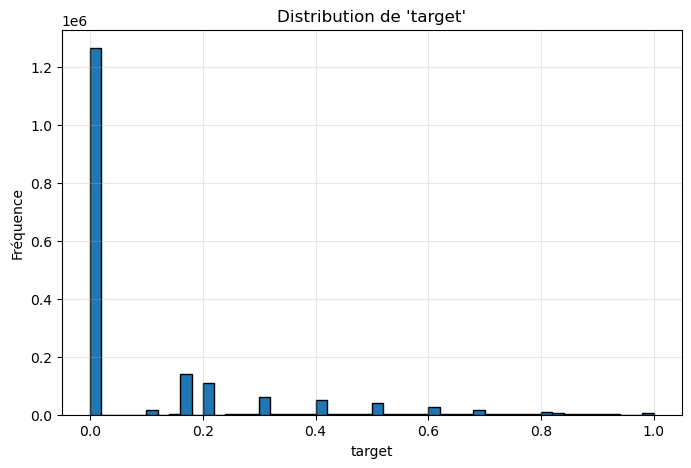

[Stage 22:>                                                         (0 + 1) / 1]

Valeurs manquantes : 0 / 1804874 (0.00%)


In [11]:
describe_col(train, "target")

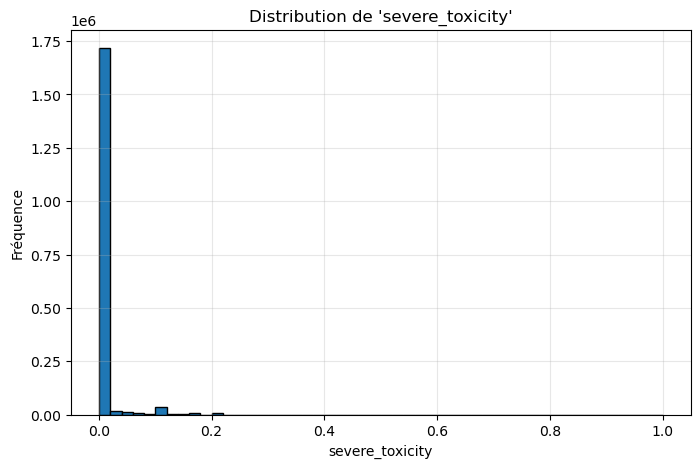

[Stage 29:>                                                         (0 + 1) / 1]

Valeurs manquantes : 0 / 1804874 (0.00%)


In [12]:
describe_col(train, "severe_toxicity")

A faire encore dans cette partie :
- étudier les distributions des autres features

## 2. Nettoyage et pré-traitement
- Nettoyage des commentaires (ponctuation), parsing des commentaires, normalisation, gestion des valeurs manquantes/abérrantes, encodage des features categorielles
- Feature Engineering (exemple de features à créer : nombre de mots, présence d’identités)


### 2.1 Prétraitement du texte

In [13]:
from pyspark.sql.functions import lower, regexp_replace, monotonically_increasing_id

train_std = (
    train.filter(train.comment_text.isNotNull())
    .withColumn("comment_text", lower(train.comment_text))
    .withColumn("comment_text", regexp_replace("comment_text", r"[^a-zA-Z\s]", ""))
    .withColumn("comment_text", regexp_replace("comment_text", r"\s+", " "))
)

In [14]:
from pyspark.sql.functions import monotonically_increasing_id

def compare_comments(df1, col1, df2, col2, n=5, truncate_len=60):
    """
    Affiche un Avant/Après prétraitements

    Paramètres :
    ------------
    df1, df2 : DataFrame Spark
    col1, col2 : colonnes de DataFrame Spark
    n : int
        Nombre de lignes à afficher (par défaut 5)
    truncate_len : int
        Nombre de caractères à afficher avant troncature (par défaut 60)
    """
    
    # pour réduire le temps de compil
    train_limited = df1.select(col1).limit(n)
    train_std_limited = df2.select(col2).limit(n)

    # id unique sur chaque df pour jointure
    train_with_id = train_limited.withColumn("id", monotonically_increasing_id())
    train_std_with_id = train_std_limited.withColumn("id", monotonically_increasing_id())

    # inner join sur l'id
    compare_df = train_with_id.join(train_std_with_id, on="id", how="inner") \
        .select(train_with_id[col1].alias("avant"),
            train_std_with_id[col2].alias("après"))

    compare_df.show(truncate=60)

    # pour réutilisation éventuelle
    return compare_df


In [15]:
compare_comments(train, "comment_text", train_std, "comment_text") # AVANT/APRES

[Stage 33:>                                                         (0 + 1) / 1]

+------------------------------------------------------------+------------------------------------------------------------+
|                                                       avant|                                                       après|
+------------------------------------------------------------+------------------------------------------------------------+
|This is so cool. It's like, 'would you want your mother t...|this is so cool its like would you want your mother to re...|
|Thank you!! This would make my life a lot less anxiety-in...|thank you this would make my life a lot less anxietyinduc...|
|This is such an urgent design problem; kudos to you for t...|this is such an urgent design problem kudos to you for ta...|
|Is this something I'll be able to install on my site? Whe...|is this something ill be able to install on my site when ...|
|                        haha you guys are a bunch of losers.|                         haha you guys are a bunch of losers|
+-------

DataFrame[avant: string, après: string]

**Suppression des stop words**

Stop words are the words in a stop list (or stoplist or negative dictionary) which are filtered out ("stopped") before or after processing of natural language data (i.e. text) because they are deemed to have little semantic value or are otherwise insignificant for the task at hand. 

« Stop Word ». Wikipedia, 12 août 2025. Wikipedia, https://en.wikipedia.org/w/index.php?title=Stop_word&oldid=1305565804.




In [16]:
from pyspark.ml.feature import StopWordsRemover, Tokenizer

tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

words_data = tokenizer.transform(train_std)
clean_data = remover.transform(words_data)

In [17]:
clean_data.select("words", "filtered").show(5, truncate=60)

+------------------------------------------------------------+------------------------------------------------------------+
|                                                       words|                                                    filtered|
+------------------------------------------------------------+------------------------------------------------------------+
|[this, is, so, cool, its, like, would, you, want, your, m...|[cool, like, want, mother, read, really, great, idea, wel...|
|[thank, you, this, would, make, my, life, a, lot, less, a...|[thank, make, life, lot, less, anxietyinducing, keep, don...|
|[this, is, such, an, urgent, design, problem, kudos, to, ...|        [urgent, design, problem, kudos, taking, impressive]|
|[is, this, something, ill, be, able, to, install, on, my,...|            [something, ill, able, install, site, releasing]|
|                [haha, you, guys, are, a, bunch, of, losers]|                                 [haha, guys, bunch, losers]|
+-------

**Lemmisation**

PySpark ML n’a pas de lemmatiseur intégré, on passe donc temporairement en Pandas

In [26]:
sample_pd = clean_data.select("filtered").limit(5000).toPandas()

import nltk
from nltk.stem import WordNetLemmatizer

nltk.download("wordnet")
nltk.download("omw-1.4")

lemm = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemm.lemmatize(word) for word in tokens]

# on applique sur la colonne filtered
sample_pd["lemmatized"] = sample_pd["filtered"].apply(lemmatize_tokens)



[nltk_data] Downloading package wordnet to /home/vboxuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vboxuser/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [27]:
sample_pd["clean_text"] = sample_pd["lemmatized"].apply(lambda x: " ".join(x))

sample_spark = spark.createDataFrame(sample_pd[:10]) #on repasse en pyspark pour la comparaison

compare_comments(clean_data.limit(10), "filtered", sample_spark.limit(10), "lemmatized", n=5 ) # AVANT/APRES

+------------------------------------------------------------+------------------------------------------------------------+
|                                                       avant|                                                       après|
+------------------------------------------------------------+------------------------------------------------------------+
|[cool, like, want, mother, read, really, great, idea, wel...|[cool, like, want, mother, read, really, great, idea, wel...|
|[thank, make, life, lot, less, anxietyinducing, keep, don...|[thank, make, life, lot, less, anxietyinducing, keep, don...|
|        [urgent, design, problem, kudos, taking, impressive]|        [urgent, design, problem, kudos, taking, impressive]|
|            [something, ill, able, install, site, releasing]|            [something, ill, able, install, site, releasing]|
|                                 [haha, guys, bunch, losers]|                                   [haha, guy, bunch, loser]|
+-------

DataFrame[avant: array<string>, après: array<string>]

**Variante du Lemming — Stemming**

On tronque simplement la fin du mot --> plus rapide mais plus susceptible de perdre de l'information

In [28]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_tokens(tokens):
    return [stemmer.stem(word) for word in tokens]

sample_pd["stemmed"] = sample_pd["filtered"].apply(stem_tokens)

In [29]:
sample_pd.head()

filtered  \
0  [cool, like, want, mother, read, really, great...   
1  [thank, make, life, lot, less, anxietyinducing...   
2  [urgent, design, problem, kudos, taking, impre...   
3   [something, ill, able, install, site, releasing]   
4                        [haha, guys, bunch, losers]   

                                          lemmatized  \
0  [cool, like, want, mother, read, really, great...   
1  [thank, make, life, lot, less, anxietyinducing...   
2  [urgent, design, problem, kudos, taking, impre...   
3   [something, ill, able, install, site, releasing]   
4                          [haha, guy, bunch, loser]   

                                          clean_text  \
0  cool like want mother read really great idea w...   
1  thank make life lot less anxietyinducing keep ...   
2      urgent design problem kudos taking impressive   
3          something ill able install site releasing   
4                               haha guy bunch loser   

                                             stemmed  
0  [cool, like, want, mother, read, realli, great...  
1  [thank, make, life, lot, less, anxietyinduc, k...  
2     [urgent, design, problem, kudo, take, impress]  
3           [someth, ill, abl, instal, site, releas]  
4                          [haha, guy, bunch, loser]

In [30]:
initial_count = len(sample_pd)

sample_pd = sample_pd[
    sample_pd["clean_text"].notna() &                    # non null
    sample_pd["clean_text"].astype(str).str.strip().ne("") &  # pas juste des espaces
    (sample_pd["clean_text"].astype(str) != "[]")        # pas liste vide
]

final_count = len(sample_pd)

removed = initial_count - final_count
print(f"{removed} lignes vides supprimées (sur {initial_count} initiales).")


7 lignes vides supprimées (sur 5000 initiales).
